In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

In [65]:
def bickleyjet_fieldset_3d(times, xdim=51, ydim=51, zdim=11):
    """A Bickley Jet Field with 3D linear decay based on Hadjighasem et al 2017,
    10.1063/1.4982720"""
    U0 = 0.06266
    L = 1770.0
    r0 = 6371.0
    k1 = 2 * 1 / r0
    k2 = 2 * 2 / r0
    k3 = 2 * 3 / r0
    eps1 = 0.075
    eps2 = 0.4
    eps3 = 0.3
    c3 = 0.461 * U0
    c2 = 0.205 * U0
    c1 = c3 + ((np.sqrt(5) - 1) / 2.0) * (k2 / k1) * (c2 - c3)

    a, b = np.pi * r0, 7000.0  # domain size
    lon = np.linspace(0, a, xdim, dtype=np.float32)
    lat = np.linspace(-b / 2, b / 2, ydim, dtype=np.float32)
    depth = np.linspace(0, 1000, zdim, dtype=np.float32)
    dx, dy = lon[2] - lon[1], lat[2] - lat[1]

    U = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)
    V = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)
    W = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)

    for i in range(lon.size):
        for j in range(lat.size):
            x1 = lon[i] - dx / 2
            x2 = lat[j] - dy / 2
            for t in range(len(times)):
                time = times[t]

                f1 = eps1 * np.exp(-1j * k1 * c1 * time)
                f2 = eps2 * np.exp(-1j * k2 * c2 * time)
                f3 = eps3 * np.exp(-1j * k3 * c3 * time)
                F1 = f1 * np.exp(1j * k1 * x1)
                F2 = f2 * np.exp(1j * k2 * x1)
                F3 = f3 * np.exp(1j * k3 * x1)
                G = np.real(np.sum([F1, F2, F3]))
                G_x = np.real(np.sum([1j * k1 * F1, 1j * k2 * F2, 1j * k3 * F3]))
                U[t, 0, j, i] = (
                    U0 / (np.cosh(x2 / L) ** 2)
                    + 2 * U0 * np.sinh(x2 / L) / (np.cosh(x2 / L) ** 3) * G
                )
                V[t, 0, j, i] = U0 * L * (1.0 / np.cosh(x2 / L)) ** 2 * G_x
    
    for k in range(1, depth.size):
        U[:, k, :, :] = U[:, 0, :, :] * ( (depth.size - k) / depth.size)
        V[:, k, :, :] = V[:, 0, :, :] * ( (depth.size - k) / depth.size)

    data = {"U": U, "V": V, "W": W}
    dimensions = {"lon": lon, "lat": lat, "depth": depth, "time": times}
    allow_time_extrapolation = True if len(times) == 1 else False
    fieldset = parcels.FieldSet.from_data(
        data, dimensions, mesh="flat", allow_time_extrapolation=allow_time_extrapolation
    )
    fieldset.U.interp_method = "cgrid_velocity"
    fieldset.V.interp_method = "cgrid_velocity"
    fieldset.W.interp_method = "cgrid_velocity"
    return fieldset

def add_uniform_temp_salt_field(fieldset, times):
    """ Add a uniform temperature and salinity field to the fieldset.
    The temperature/salinity field is time-invariant and has a linear decay with depth.
    Of course, this makes no sense in reality, but it is a simple example."""
    lon = fieldset.U.grid.lon # Is this right?
    lat = fieldset.U.grid.lat
    depth = fieldset.U.grid.depth

    T = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)
    S = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)

    T[:, 0, :, :] = 20.0 # TODO: make sure the units are correct!
    S[:, 0, :, :] = 35.0

    for d in range(1, depth.size):
        T[:, d, :, :] = T[:, 0, :, :] * ( (depth.size - 0.5 * d) / depth.size)
        S[:, d, :, :] = S[:, 0, :, :] * ( (depth.size - 0.5 * d) / depth.size)

    data = {"conservative_temperature": T, "absolute_salinity": S}

    dimensions = {"lon": lon, "lat": lat, "depth": depth, "time": times}
    allow_time_extrapolation = True if len(times) == 1 else False
    fieldsetTS = parcels.FieldSet.from_data(
        data, dimensions, mesh="flat", allow_time_extrapolation=allow_time_extrapolation
    )

    #fieldsetTS.add_periodic_halo(zonal=True)
    fieldset.add_field(fieldsetTS.conservative_temperature)
    fieldset.add_field(fieldsetTS.absolute_salinity)

    return fieldset

def add_biogeochemistry_field(fieldset, times):
    lon = fieldset.U.grid.lon # Is this right?
    lat = fieldset.U.grid.lat
    depth = fieldset.U.grid.depth

    pp_phyto = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)
    bio_nanophy = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)
    bio_diatom = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)


    _, yy = np.meshgrid(fieldset.U.grid.lon, fieldset.U.grid.lat)
    r0 = 6371.0
    _, dy = np.pi * r0, 7000.0  # domain size
    f_pp_phyto = np.cos(yy/dy)
    f_bio_nanophy = np.cos(yy/dy + np.pi/24) # shifted
    f_bio_diatom = np.cos(yy/dy - np.pi/24) # shifted

    pp_phyto[:, 0, :, :] = 50 * f_pp_phyto # TODO: Get the units right!
    bio_nanophy[:, 0, :, :] = 5 * f_bio_nanophy
    bio_diatom[:, 0, :, :] = 10 * f_bio_diatom

    for d in range(1, depth.size):
        pp_phyto[:, d, :, :] = pp_phyto[:, 0, :, :] * ( (depth.size - 0.5 * d) / depth.size)
        bio_nanophy[:, d, :, :] = bio_nanophy[:, 0, :, :] * ( (depth.size - 0.5 * d) / depth.size)
        bio_diatom[:, d, :, :] = bio_diatom[:, 0, :, :] * ( (depth.size - 0.5 * d) / depth.size)

    data = {"pp_phyto": pp_phyto, "bio_nanophy": bio_nanophy, "bio_diatom": bio_diatom}

    dimensions = {"lon": lon, "lat": lat, "depth": depth, "time": times}
    allow_time_extrapolation = True if len(times) == 1 else False
    fieldsetbgc = parcels.FieldSet.from_data(
        data, dimensions, mesh="flat", allow_time_extrapolation=allow_time_extrapolation
    )

    #fieldsetbgc.add_periodic_halo(zonal=True)
    fieldset.add_field(fieldsetbgc.pp_phyto)
    fieldset.add_field(fieldsetbgc.bio_nanophy)
    fieldset.add_field(fieldsetbgc.bio_diatom)

    return fieldset


def add_wind_field(fieldset, times):
    """ Horizontal wind field with a sinusoidal variation in time."""
    lon = fieldset.U.grid.lon # Is this right?
    lat = fieldset.U.grid.lat

    wind_U = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)
    wind_V = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)

    _, yy = np.meshgrid(fieldset.U.grid.lon, fieldset.U.grid.lat)
    r0 = 6371.0
    _, dy = np.pi * r0, 7000.0  # domain size
    f_wind = np.cos(yy/dy)

    wind_U[0, :, :] = 10 * f_wind

    # vary the wind speed with time
    for time in range(1, times.size):
        wind_U[time, :, :] = wind_U[0, :, :] * np.sin(2 * np.pi * time / times.size)

    data = {"Wind_U": wind_U, "Wind_V": wind_V}
    
    dimensions = {"lon": lon, "lat": lat, "time": times}
    allow_time_extrapolation = True if len(times) == 1 else False
    fieldsetwind = parcels.FieldSet.from_data(
        data, dimensions, mesh="flat", allow_time_extrapolation=allow_time_extrapolation
    )

    #fieldsetwind.add_periodic_halo(zonal=True)
    fieldset.add_field(fieldsetwind.Wind_U)
    fieldset.add_field(fieldsetwind.Wind_V)

    return fieldset



def add_stokes_field(fieldset, times):
    """ Horizontal wave field invariant in time."""
    lon = fieldset.U.grid.lon # Is this right?
    lat = fieldset.U.grid.lat

    stokes_U = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)
    stokes_V = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)
    wave_Tp = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)

    xx, yy = np.meshgrid(fieldset.U.grid.lon, fieldset.U.grid.lat)
    r0 = 6371.0
    dx, dy = np.pi * r0, 7000.0  # domain size

    stokes_U[0, :, :] = -np.sin(xx * np.pi / (dx) )
    wave_Tp[0, :, :] = 10 * np.cos(yy/dy)

    data = {"Stokes_U": stokes_U, "Stokes_V": stokes_V, 'wave_Tp': wave_Tp}
    
    dimensions = {"lon": lon, "lat": lat, "time": times}
    allow_time_extrapolation = True if len(times) == 1 else False
    fieldsetStokes = parcels.FieldSet.from_data(
        data, dimensions, mesh="flat", allow_time_extrapolation=allow_time_extrapolation
    )

    #fieldsetStokes.add_periodic_halo(zonal=True)
    fieldset.add_field(fieldsetStokes.Stokes_U)
    fieldset.add_field(fieldsetStokes.Stokes_V)
    fieldset.add_field(fieldsetStokes.wave_Tp)

    return fieldset


In [66]:
times = np.arange(0, 1.1, 0.1) * 86400
fieldsetBJ3D = bickleyjet_fieldset_3d(times=times)
fieldsetBJ3D = add_uniform_temp_salt_field(fieldsetBJ3D, times)
fieldsetBJ3D = add_biogeochemistry_field(fieldsetBJ3D, times)
fieldsetBJ3D = add_wind_field(fieldsetBJ3D, times)
fieldsetBJ3D = add_stokes_field(fieldsetBJ3D, times)


fieldsetBJ3D.add_constant("halo_west", fieldsetBJ3D.U.grid.lon[0])
fieldsetBJ3D.add_constant("halo_east", fieldsetBJ3D.U.grid.lon[-1])
fieldsetBJ3D.add_periodic_halo(zonal=True)


def ZonalBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west


20015.086 0.0
22016.594 -2001.5078


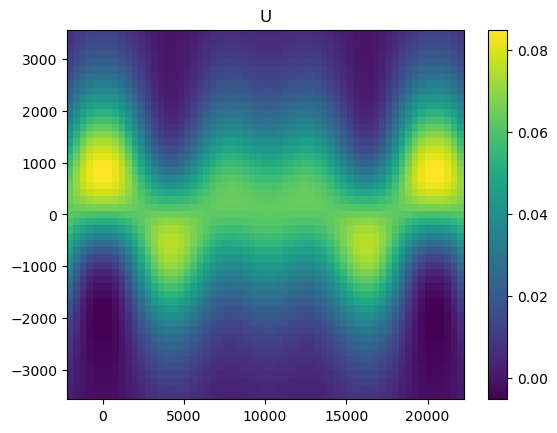

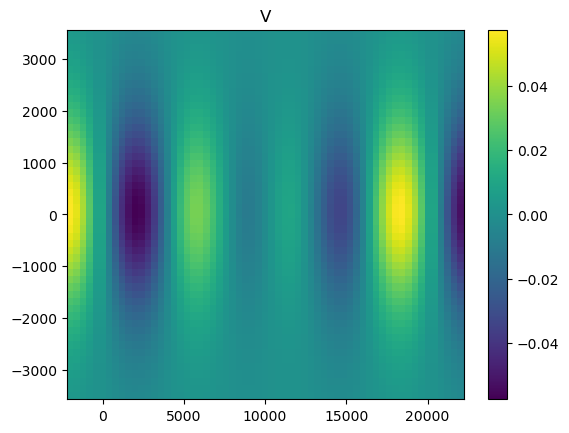

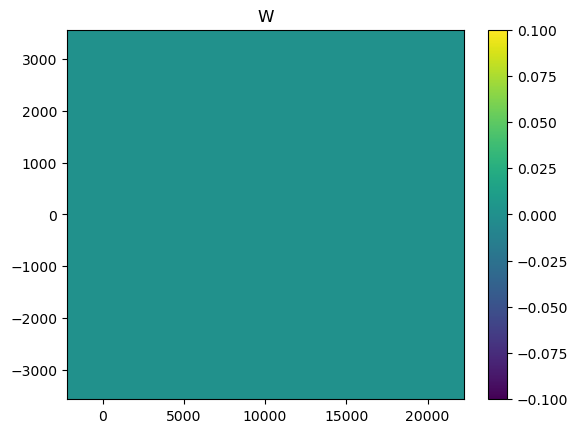

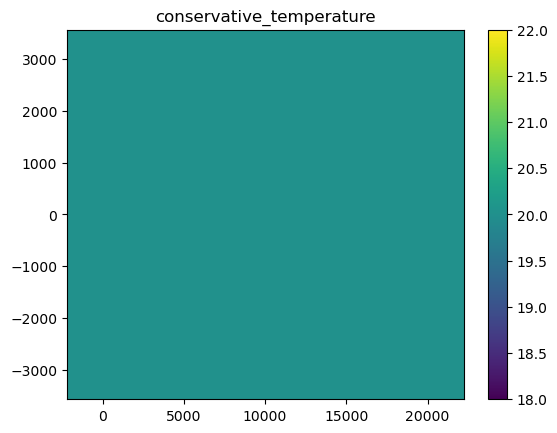

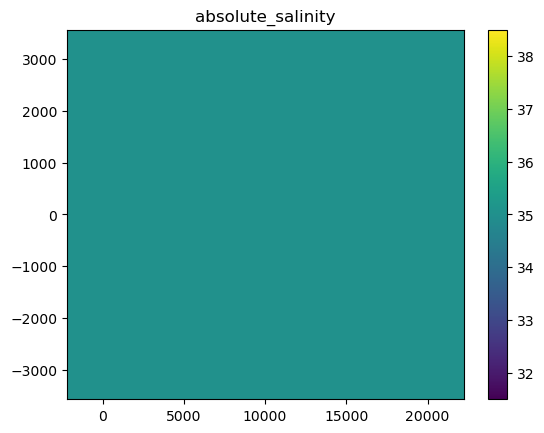

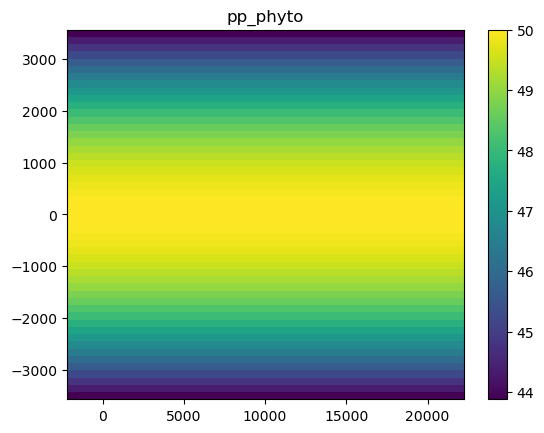

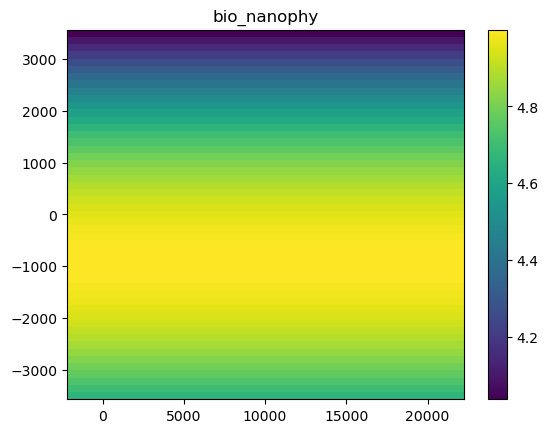

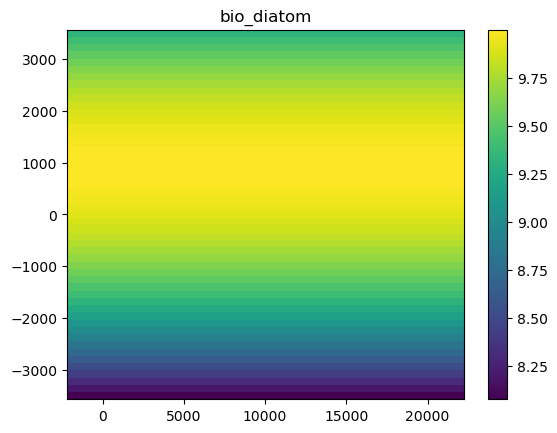

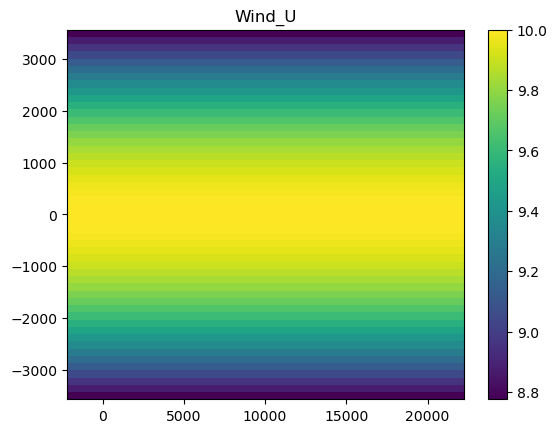

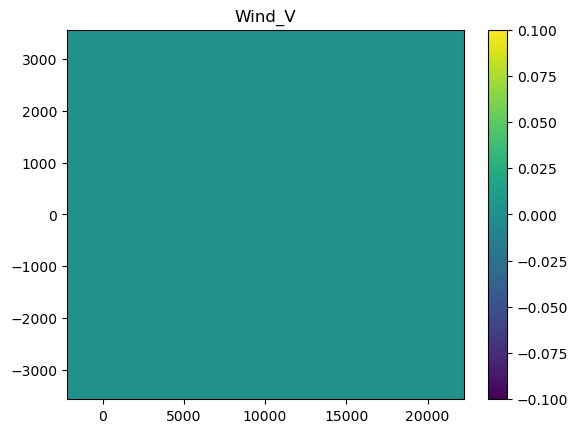

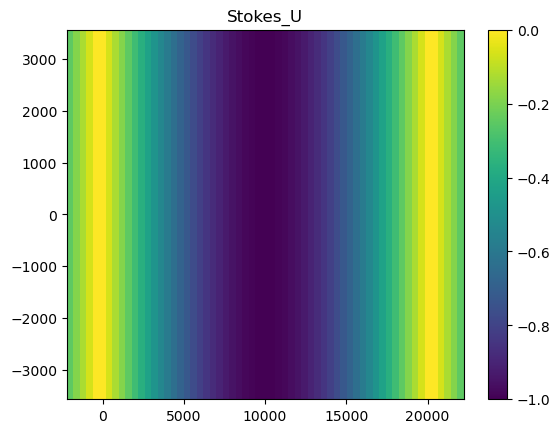

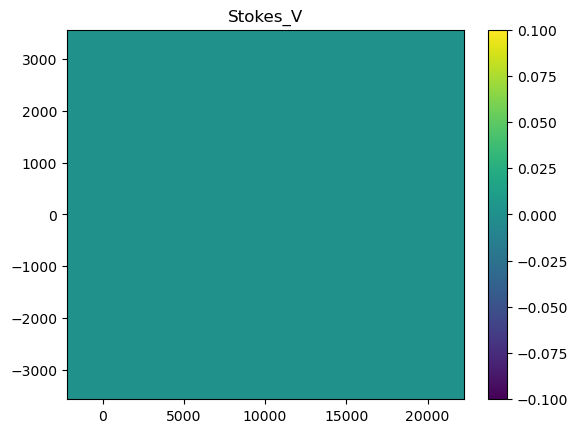

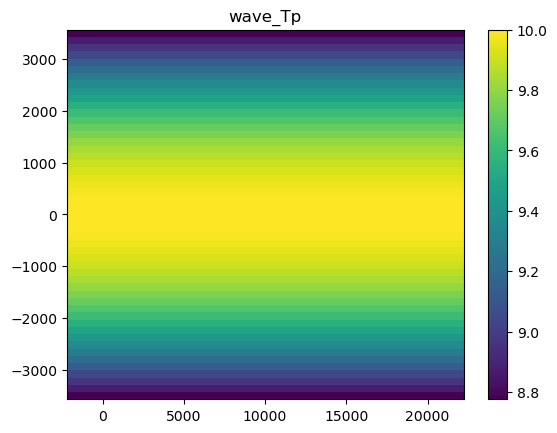

In [67]:
for field in fieldsetBJ3D.get_fields():
    if type(field) == parcels.Field:
        xx,yy = np.meshgrid(field.grid.lon,field.grid.lat)
        if len(field.data.shape) == 4:
            cb = plt.pcolormesh(xx, yy, field.data[0,0,:,:])
        else:
            cb = plt.pcolormesh(xx, yy, field.data[0,:,:])
        plt.colorbar(cb)
        plt.title(field.name)
        plt.show()
